# Demo: Linear Shallow Water Model

In [1]:
import equinox as eqx
from jaxtyping import Array
import autoroot
import jax
import jax.numpy as jnp
from fieldx._src.domain.domain import Domain
from fieldx._src.domain.time import TimeDomain
from finitevolx import MaskGrid, x_avg_2D, y_avg_2D, center_avg_2D, difference, relative_vorticity, reconstruct

import matplotlib.pyplot as plt
import numpy as np
from jax.config import config
config.update("jax_enable_x64", True)

%matplotlib inline


%load_ext autoreload
%autoreload 2

In [2]:
def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(figsize=(8, 2))

    pts = ax.imshow(field.T, origin="lower", cmap="coolwarm")
    plt.colorbar(pts)

    plt.tight_layout()
    plt.show()

## Domain

In [3]:
Nx, Ny = 200, 104
dx, dy = 5e3, 5e3
Lx, Ly = Nx * dx, Ny * dy

In [4]:
h_domain = Domain(xmin=(0.0, 0.0), xmax=(Lx, Ly), Lx=(Lx,Ly), Nx=(Nx,Ny), dx=(dx,dy))
h_domain

Domain(
  xmin=(0.0, 0.0),
  xmax=(1000000.0, 520000.0),
  dx=(5000.0, 5000.0),
  Nx=(200, 104),
  Lx=(1000000.0, 520000.0),
  ndim=2
)

In [5]:
u_domain = Domain(xmin=(-0.5, 0.0), xmax=(Lx+0.5*dx, Ly), Lx=(Lx+dx,Ly), Nx=(Nx+1,Ny), dx=(dx,dy))
v_domain = Domain(xmin=(0.0, -0.5), xmax=(Lx, Ly+0.5*dy), Lx=(Lx,Ly+0.5*dy), Nx=(Nx,Ny+1), dx=(dx,dy))
u_domain, v_domain

(Domain(
   xmin=(-0.5, 0.0),
   xmax=(1002500.0, 520000.0),
   dx=(5000.0, 5000.0),
   Nx=(201, 104),
   Lx=(1005000.0, 520000.0),
   ndim=2
 ),
 Domain(
   xmin=(0.0, -0.5),
   xmax=(1000000.0, 522500.0),
   dx=(5000.0, 5000.0),
   Nx=(200, 105),
   Lx=(1000000.0, 522500.0),
   ndim=2
 ))

In [6]:
class ArakawaCDomain(eqx.Module):
    h: Domain = eqx.field(static=True)
    u: Domain = eqx.field(static=True)
    v: Domain = eqx.field(static=True)

In [7]:
domain = ArakawaCDomain(h=h_domain, u=u_domain, v=v_domain)

## Model Parameter

In [8]:
class Params(eqx.Module):
    gravity: float = eqx.field(static=True)
    depth: float = eqx.field(static=True)
    coriolis_f0: float = eqx.field(static=True)
    coriolis_beta: float = eqx.field(static=True)
    
    def coriolis_param(self, Y: Array):
        return self.coriolis_f0 + Y * self.coriolis_beta
    
    def lateral_viscosity(self, dx: Array):
        return 1e-3 * self.coriolis_f0 * dx ** 2
    
    @property
    def phase_speed(self):
        return jnp.sqrt(self.gravity * self.depth)
    
    def rossby_radius(self, Y: Array):
        return jnp.sqrt(self.gravity * self.depth) / self.coriolis_param(Y=Y).mean()

In [9]:
params = Params(gravity=9.81, depth=100.0, coriolis_f0=2e-4, coriolis_beta=2e-11)

### Mask

In [10]:
X = h_domain.grid_axis[0]

mask = jnp.ones_like(X)
# mask = mask.at[-1].set(0.0)
# mask = mask.at[:, 0].set(0.0)
# mask = mask.at[:, -1].set(0.0)
# mask = mask.at[0].set(0.0)
masks = MaskGrid.init_mask(mask, "center")

### Initial Conditions

#### Zonal Velocity

In [11]:
Y_ = domain.u.grid_axis[1]
y_ = domain.u.coords_axis[1]
Ny_ = domain.u.Nx[1]
Lx_ = domain.u.Lx[0]
u0 = 10 * jnp.exp( - (Y_ - y_[Ny_//2])**2 / (0.02 * Lx_)**2)
u0 = u0.at[-1].set(0.0)
u0 = jnp.zeros(u_domain.Nx)

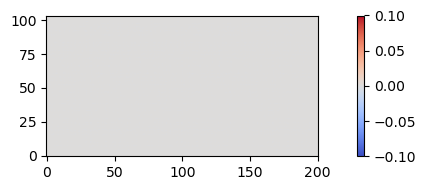

In [12]:
plot_field(u0)

#### Meridional Velocity, V

In [13]:
v0 = jnp.zeros(domain.v.Nx)
u0.shape, v0.shape

((201, 104), (200, 105))

#### Height

In [14]:
h_geostrophy = jnp.cumsum(
    - domain.h.dx[1] 
    * x_avg_2D(u0)
    * params.coriolis_param(domain.h.grid_axis[1]) / params.gravity, 
    axis=0
)

h0 = (
    params.depth
    + h_geostrophy
    # make sure h0 is centered around depth
    - h_geostrophy.mean()
    # small perturbation
    + 0.2 * jnp.sin(domain.h.grid_axis[1] / domain.h.Lx[0] * 10. * jnp.pi) *
    jnp.cos(domain.h.grid_axis[1] / domain.h.Lx[1] * 8. * jnp.pi)
)

In [73]:
# Gaussian Blob
h0 = np.exp(
    -((domain.h.grid_axis[0]-domain.h.Lx[0]/2.7)**2/
      (2*(0.05E+6)**2) + 
      (domain.h.grid_axis[1]-domain.h.Lx[1]/4)**2/(2*(0.05E+6)**2)))

h0 = 10000. - jnp.tanh(20.0*((
    domain.h.grid_axis[1]-
    jnp.mean(domain.h.coords_axis[1]))/
    jnp.max(domain.h.coords_axis[1])))*400.

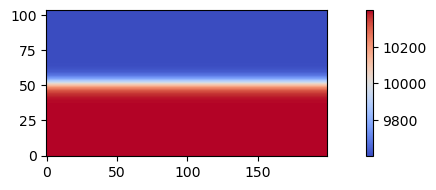

In [74]:
plot_field(h0)

### Boundary Conditions

In [75]:
def enforce_boundaries(u, grid: str="h"):
    if grid == "u":
        u = u.at[-1,:].set(0.0)
    if grid == "v":
        u = u.at[:,-1].set(0.0)
    return u

### State

In [76]:
class State(eqx.Module):
    h: Array
    u: Array
    v: Array

In [77]:
state = State(h=h0, u=u0, v=v0)

## Equation of Motion


In [103]:
def u_linear_rhs(state: State, domain: ArakawaCDomain, params: Params):
    """
    Eq:
        ∂u/∂t = fv - g ∂h/∂x
    """
    # parse state
    h, u, v = state.h, state.u, state.v
    
    # pad arrays
    h_pad: Float[Array, "Nx+2 Ny"] = jnp.pad(h, pad_width=((1,1),(0,0)), mode="edge")
    v_pad: Float[Array, "Nx+2 Ny+1"] = jnp.pad(v, pad_width=((1,1),(0,0)), mode="constant")
    
    v_avg: Float[Array, "Nx+1 Ny"] = center_avg_2D(v_pad)
    dh_dx: Float[Array, "Nx+1 Ny"] = difference(h_pad, step_size=domain.h.dx[0], axis=0, derivative=1)
    
    f = params.coriolis_param(domain.u.grid_axis[1])
    beta = 1.6e-11
    # f += beta * domain.u.grid_axis[1]
    # f = params.coriolis_f0 + beta * domain.u.grid_axis[1]
    # f = params.coriolis_f0

    u_rhs: Float[Array, "Nx+1 Ny"] = f * v_avg - params.gravity * dh_dx
    
    
    # u_rhs = enforce_boundaries(u_rhs, "u")

    # apply masks
    # u_rhs *= masks.face_u.values
    
    return u_rhs

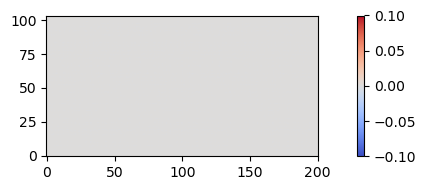

In [104]:
u_rhs = u_linear_rhs(state, domain, params)

plot_field(u_rhs)

In [105]:
def v_linear_rhs(state: State, domain: ArakawaCDomain, params: Params):
    # parse state
    h, u, v = state.h, state.u, state.v
    
    # pad arrays
    h_pad: Float[Array, "Nx Ny+2"] = jnp.pad(h, pad_width=((0,0),(1,1)), mode="edge")
    u_pad: Float[Array, "Nx+1 Ny+2"] = jnp.pad(u, pad_width=((0,0),(1,1)), mode="constant")
    
    # calculate RHS
    u_avg: Float[Array, "Nx Ny+1"] = center_avg_2D(u_pad)
    dh_dy: Float[Array, "Nx Ny+1"] = difference(h_pad, step_size=domain.h.dx[1], axis=1, derivative=1)
    
    f = params.coriolis_param(domain.v.grid_axis[1])
    beta = 1.6e-11
    # f += beta * domain.v.grid_axis[1]
    # f = params.coriolis_f0 + beta * domain.v.grid_axis[1]
    # f = params.coriolis_f0

    
    v_rhs: Float[Array, "Nx Ny+1"] = - f * u_avg - params.gravity * dh_dy
    
    # v_rhs = enforce_boundaries(v_rhs, "v")

    # apply masks
    # v_rhs *= masks.face_v.values
    
    return v_rhs

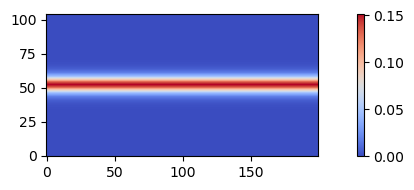

In [106]:
v_rhs = v_linear_rhs(state, domain, params)

plot_field(v_rhs)

In [107]:
def h_linear_rhs(state: State, domain: ArakawaCDomain, params: Params):
    """
    Eq:
       ∂h/∂t = - H (∂u/∂x + ∂v/∂y)
    """
    
    # parse state
    h, u, v = state.h, state.u, state.v
    
    # calculate RHS
    du_dx: Float[Array, "Nx Ny"] = difference(u, step_size=domain.h.dx[0], axis=0, derivative=1)
    dv_dy: Float[Array, "Nx Ny"] = difference(v, step_size=domain.h.dx[1], axis=1, derivative=1)

    h_rhs: Float[Array, "Nx Ny"] = - params.depth * (du_dx + dv_dy)

    # apply masks
    h_rhs *= masks.center.values
    
    return h_rhs

def h_nonlinear_rhs(state: State, domain: ArakawaCDomain, params: Params):
    """
    Eq:
        ∂h/∂t + ∂/∂x((H+h)u) + ∂/∂y((H+h)v) = 0
    """
    
    # parse state
    h, u, v = state.h, state.u, state.v
    
    
    
    h_pad: Float[Array, "Nx+2 Ny+2"] = jnp.pad(h, pad_width=((1,1),(1,1)), mode="edge")
    
    
    # calculate h fluxes
    uh_flux: Float[Array, "Nx+1 Ny"] = reconstruct(q=h_pad[:,1:-1], u=u, u_mask=masks.face_u, dim=0, num_pts=5, method="wenoz")
    vh_flux: Float[Array, "Nx Ny+1"] = reconstruct(q=h_pad[1:-1,:], u=v, u_mask=masks.face_v, dim=1, num_pts=5, method="wenoz")
    
    # calculate RHS
    dhu_dx: Float[Array, "Nx Ny"] = difference(uh_flux, step_size=domain.h.dx[0], axis=0, derivative=1)
    dhv_dy: Float[Array, "Nx Ny"] = difference(vh_flux, step_size=domain.h.dx[1], axis=1, derivative=1)

    h_rhs: Float[Array, "Nx Ny"] = - (dhu_dx + dhv_dy)

    # apply masks
    # h_rhs *= masks.center.values
    
    return h_rhs

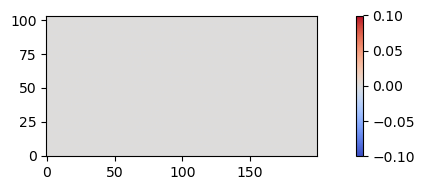

In [108]:
h_rhs = h_linear_rhs(state, domain, params)
h_rhs = h_nonlinear_rhs(state, domain, params)

plot_field(h_rhs)

### Vector Field

In [109]:
def equation_of_motion(t: float, state: State, args):
    
    params, domain = args
    
    h, u, v = state.h, state.u, state.v
    
    # pad arrays
    # h = jnp.pad(h[1:-1,1:-1], pad_width=((1,1),(1,1)), mode="edge")
    # u = jnp.pad(u[1:-1,1:-1], pad_width=((1,1),(1,1)), mode="constant", constant_values=0.0)
    # v = jnp.pad(v[1:-1,1:-1], pad_width=((1,1),(1,1)), mode="constant", constant_values=0.0)
    
    # apply boundary conditions
    h = enforce_boundaries(h, grid="h")
    u = enforce_boundaries(u, grid="u")
    v = enforce_boundaries(v, grid="v")
    
    # update state
    state = eqx.tree_at(lambda x: x.h, state, h)
    state = eqx.tree_at(lambda x: x.u, state, u)
    state = eqx.tree_at(lambda x: x.v, state, v)
    
    # calculate RHS
    u_rhs = u_linear_rhs(state, domain, params)
    v_rhs = v_linear_rhs(state, domain, params)
    h_rhs = h_linear_rhs(state, domain, params)
    # h_rhs = h_nonlinear_rhs(state, domain, params)
    
    # update state
    state = eqx.tree_at(lambda x: x.h, state, h_rhs)
    state = eqx.tree_at(lambda x: x.u, state, u_rhs)
    state = eqx.tree_at(lambda x: x.v, state, v_rhs)
    
    return state

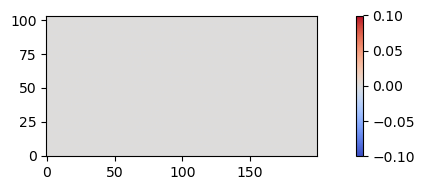

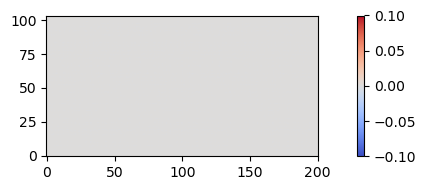

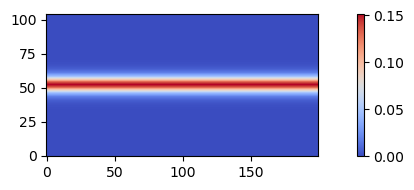

In [110]:
state_ = equation_of_motion(0, state, (params, domain))


plot_field(state_.h)
plot_field(state_.u)
plot_field(state_.v)

## TIme Integration

In [111]:
import pandas as pd
import diffrax as dfx


dt = 0.125 * min(h_domain.dx[0], h_domain.dx[1]) / jnp.sqrt(params.gravity * params.depth)

tmin = 0.0
num_years = 1
num_days = 0.1
tmax = pd.to_timedelta(num_years * num_days, unit="days").total_seconds()
num_save = 10

In [112]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [113]:
ts

Array([   0.,  960., 1920., 2880., 3840., 4800., 5760., 6720., 7680.,
       8640.], dtype=float64)

In [114]:

solver = dfx.Tsit5()
stepsize_controller = dfx.ConstantStepSize() #dfx.PIDController(rtol=1e-4, atol=1e-4)

In [115]:
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(equation_of_motion),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=state,
    saveat=saveat,
    args=(params, domain),
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

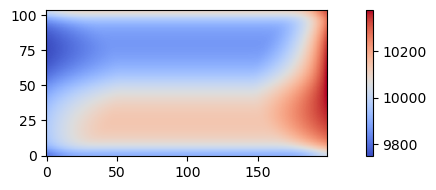

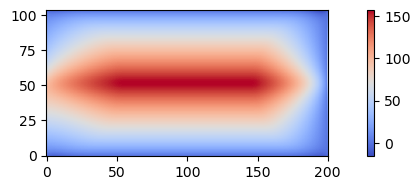

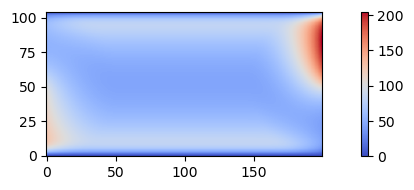

In [116]:
plot_field(sol.ys.h[-1])
plot_field(sol.ys.u[-1])
plot_field(sol.ys.v[-1])

In [117]:
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(equation_of_motion),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=State(h=sol.ys.h[-1], u=sol.ys.u[-1], v=sol.ys.v[-1]),
    saveat=saveat,
    args=(params, domain),
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

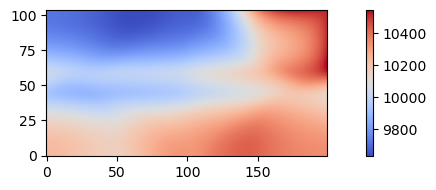

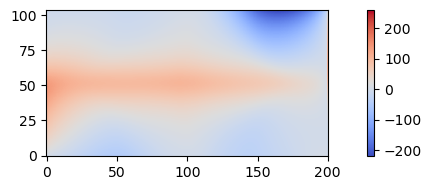

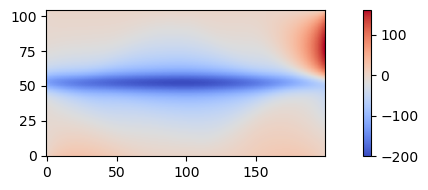

In [118]:
plot_field(sol.ys.h[-1])
plot_field(sol.ys.u[-1])
plot_field(sol.ys.v[-1])